# TDoA (Time Difference of Arrival) localization

In [67]:
import pathlib
import numpy as np
import pandas as pd
import scipy
import scipy.io
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt

## Visualizing all the recievers on a plot

In [7]:
measurement_path = pathlib.Path('dataset/T20230222_1337_PoC_RDs_DMRS_UDP_Serial_Array_332_346_353_354_364_419_120.mat')
recievers = pd.read_csv(pathlib.Path('dataset/dot_coordinates.csv'), index_col='id_short')

In [8]:
recievers

,id_long,label,x,y,z
id_short,,,,,
120,TD3W211120,DOT20,25.082908,-9.11154,4.796871
126,TD3W211126,DOT21,42.465674,-17.51020,3.592475
131,TD3W211131,DOT22,39.125749,-37.54210,3.495790
133,TD3W211133,DOT23,32.514523,-29.61950,3.519441
153,TD3W211153,DOT24,10.790700,-42.59800,2.628408
323,TD3W201323,DOT01,43.170114,-8.38082,3.513311
332,TD3W201332,DOT02,24.468584,-21.65040,4.785801
338,TD3W201338,DOT04,32.171942,-21.73400,2.605779
346,TD3W201346,DOT05,8.460898,-18.29430,4.241591


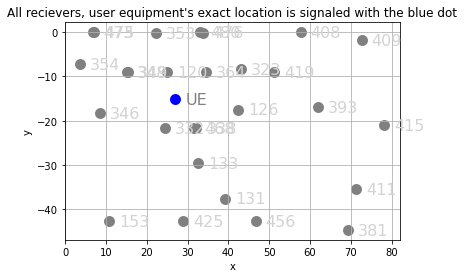

In [9]:
cmap = matplotlib.colormaps['Spectral']
fig, ax = plt.subplots()

recievers.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c= 'gray')


ue_data = pd.read_csv('dataset/configuration.csv')

ue_data.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c='blue')


for k, v in ue_data.iterrows():
    ax.annotate("UE", v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')

for k, v in recievers.iterrows():
    ax.annotate(k, v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='lightgrey')
    
plt.title("All recievers, user equipment's exact location is signaled with the blue dot")

ax.grid(True)

## Visualizing the active recievers on a plot

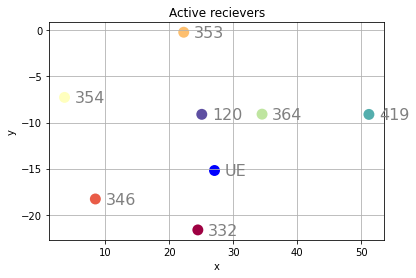

In [10]:
cmap = matplotlib.colormaps['Spectral']
fig, ax = plt.subplots()

ue_data.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c='blue', colormap=cmap)

active_dots = [int(x) for x in measurement_path.stem.split('_')[-7:]]
df = recievers.loc[active_dots]
df.plot('x', 'y', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(df)), colormap=cmap)

for k, v in ue_data.iterrows():
    ax.annotate("UE", v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')

for k, v in df.iterrows():
    ax.annotate(k, v[['x', 'y']],
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=16, color='grey')
    
plt.title("Active recievers")
    
ax.grid(True)

c:\Users\pmaty\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


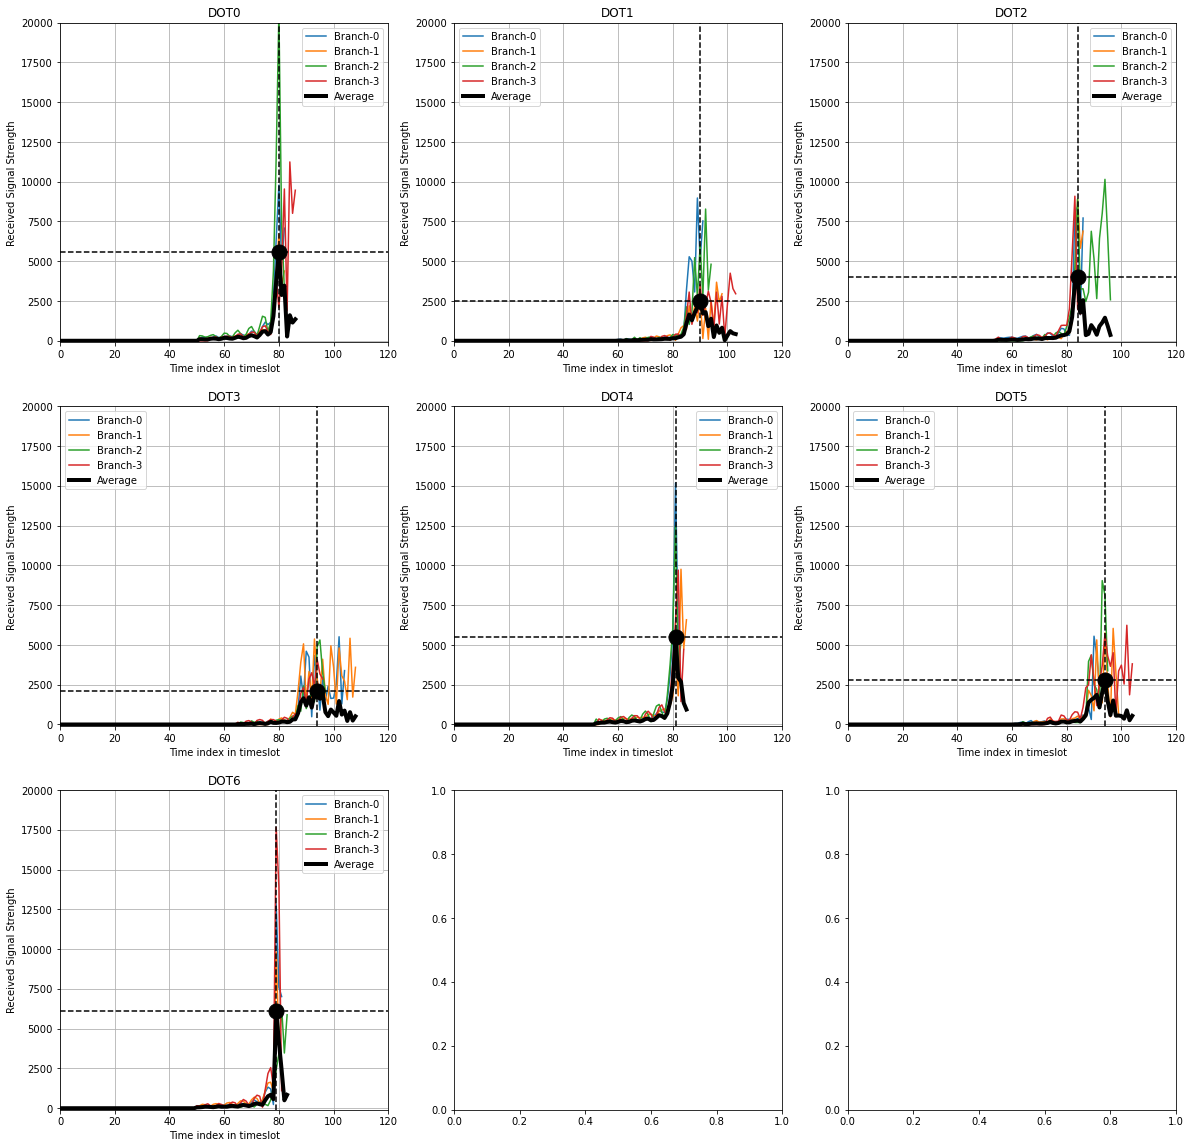

In [125]:
measurement_data = scipy.io.loadmat(measurement_path)

data = pd.DataFrame(measurement_data['UDP_data'][99]).applymap(
                                    lambda x: x[0][0] if len(x[0]) == 1 else x[0])[[
                                        'dpePortSel', 'dpeBrSel', 'RxyT', 'Kmaxm1'
                                    ]].drop_duplicates(subset=['dpePortSel', 'dpeBrSel'], keep='first')

row_num, col_num = 3, 3
fig, ax = plt.subplots(figsize=(20, 20), nrows=row_num, ncols=col_num)
for ax_num in range(row_num*col_num):
    if(ax_num > 6):
        break
    average = []
    for _, measurement in data.query("dpePortSel == @ax_num").iterrows():
        record = np.concatenate((np.zeros(measurement['Kmaxm1']), np.abs(measurement['RxyT'])))
        ax[ax_num//col_num, ax_num%col_num].plot(record, label=f"Branch-{measurement['dpeBrSel']}", )
        ax[ax_num//col_num, ax_num%col_num].set_xlim([0,120])
        ax[ax_num//col_num, ax_num%col_num].set_ylim([-100,20000])
        ax[ax_num//col_num, ax_num%col_num].set_title("DOT" + str(ax_num))
        ax[ax_num//col_num, ax_num%col_num].set_xlabel('Time index in timeslot')
        ax[ax_num//col_num, ax_num%col_num].set_ylabel('Received Signal Strength')
        ax[ax_num//col_num, ax_num%col_num].grid(True)
        if len(average) < len(record):
            average = np.concatenate((average, np.zeros(len(record) - len(average))))
        elif len(average) > len(record):
            record = np.concatenate((record, np.zeros(len(average) - len(record))))
        average = np.add(average, record)
    #average = average/7
    average = list(map(lambda x: x/7, average))
    ax[ax_num//col_num, ax_num%col_num].plot(average, label="Average", linewidth=4, markersize=7, color='black')
    ax[ax_num//col_num, ax_num%col_num].legend()

    #peaks, _ = scipy.signal.find_peaks(average, prominence=1)
    peaks = np.argmax(average)
    ax[ax_num//col_num, ax_num%col_num].axhline(y=average[peaks], linestyle = '--', color='black')
    ax[ax_num//col_num, ax_num%col_num].axvline(peaks, linestyle = '--', color='black')
    ax[ax_num//col_num, ax_num%col_num].plot(peaks, average[peaks], marker='o', markersize=15, color='black')